In [207]:
%pylab inline 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def load_acquisition_data(filelocation):
    format = '%Y-%m-%d %H:%M:%S,%f'
    df =pd.read_csv(filelocation, sep=';',parse_dates=True);
    times = pd.to_datetime(df.DateTime , format=format)
    df.set_index(times, inplace=True)
    return df

pumpdata = load_acquisition_data('..\data\PumpMeasuresFormated.csv')

Populating the interactive namespace from numpy and matplotlib


We will normalize the entryload to have a value varying between 0 and 100

In [208]:
pumpdata["NormEntryLoad"]= pumpdata["EntryLoad"]/255*100

With the statsmodel library we will clean the noise contained in the current of the pump measured and we keep the trend. This process is already shown in the data visualisation and analysis.

Current Filtered represents the trend of the current obtained by the seasonal analysis <br>
The value measured of the current is obtained in labjack U3 via an analog to numeric converter with 12 bits precision <br>
An amplifier operational with a gain and offset is used to convert the measure of the tension on the shunt to
a voltage varying form 0 to 2.44 volt <br>
The amplifier operational function transfert is a linear function with a gain of 11.8 and an offset of -3.85 <br>
The shunt resistor value is 0.5 ohm <br>
The formula here after transform the numeric value returned by the CAN to the intensity consumed by the pump


In [209]:
import statsmodels.api as sm
#Feature ingeneering add the filtered current column in the dataframe
decompfreq = 50
res = sm.tsa.seasonal_decompose(pumpdata.PumpCurrent.interpolate(),freq=decompfreq, model='additive')

pumpdata["CurrentFiltered"] = ((res.trend/4095)*2.44 +3.85)/(11.8*0.5)

C:\Anaconda343\lib\site-packages\statsmodels\tsa\filters\filtertools.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return np.r_[[np.nan] * head, x, [np.nan] * tail]


The flow meter provide 97 pulse for each litter <br>
The flow measure period is 10s <br>
The flow in l/h is obtained by (Nbpulse/97)*360

In [210]:
#convert the flow pulse
pumpdata["Flow"]=(pumpdata["Flow"]/97)*360

In [211]:
#Remove row containing NaN value
pumpdataCleaned= pumpdata.dropna()

The current decomposition process with the stats model library produce some NaN values. We will remove these records from the dataset in the next steps.

In [212]:
from sklearn.model_selection import train_test_split

def split_train_test(data) :
    trainSet, testSet = train_test_split(data, test_size = 0.2, random_state=2)
    return trainSet, testSet

In [213]:
pumpdataCleaned.head()

,Id,Cycle,DateTime,Flow,EntryLoad,OutputLoad,PumpCurrent,PumpVelocity,NormEntryLoad,CurrentFiltered
DateTime,,,,,,,,,,
2017-04-23 14:44:05.248,25,1,"2017-04-23 14:44:05,248",371.134021,130,100,4027,10,50.980392,1.052355
2017-04-23 14:44:18.277,26,1,"2017-04-23 14:44:18,277",371.134021,125,100,3981,10,49.019608,1.052139
2017-04-23 14:44:31.306,27,1,"2017-04-23 14:44:31,306",367.422680,120,100,3590,10,47.058824,1.050217
2017-04-23 14:44:44.337,28,1,"2017-04-23 14:44:44,337",371.134021,115,100,4280,10,45.098039,1.049443
2017-04-23 14:44:57.367,29,1,"2017-04-23 14:44:57,367",363.711340,110,100,3709,10,43.137255,1.049048


In [183]:
pumpdataCleaned.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1930 entries, 2017-04-23 14:44:05.248000 to 2017-04-23 22:45:48.584000
Data columns (total 10 columns):
Id                 1930 non-null int64
Cycle              1930 non-null int64
DateTime           1930 non-null object
Flow               1930 non-null float64
EntryLoad          1930 non-null int64
OutputLoad         1930 non-null int64
PumpCurrent        1930 non-null int64
PumpVelocity       1930 non-null int64
NormEntryLoad      1930 non-null float64
CurrentFiltered    1930 non-null float64
dtypes: float64(3), int64(6), object(1)
memory usage: 165.9+ KB


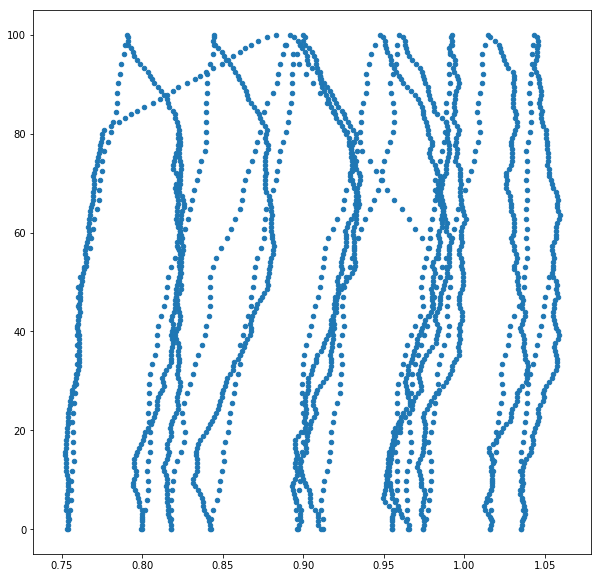

In [184]:
plt.figure(figsize=(10,10))
plt.scatter(pumpdataCleaned.CurrentFiltered, pumpdataCleaned.NormEntryLoad, s=20)

In [185]:
corrMatrix = pumpdataCleaned.corr()
corrMatrix["Flow"].sort_values(ascending=False)

Flow               1.000000
CurrentFiltered    0.524873
PumpCurrent        0.506637
EntryLoad          0.492545
NormEntryLoad      0.492545
OutputLoad         0.407186
PumpVelocity       0.390925
Id                -0.575186
Cycle             -0.592585
Name: Flow, dtype: float64

In [186]:
trainSet, testSet = split_train_test(pumpdataCleaned)

We create a new dataset keeping only the most important parameters of the model:
- Current consumed by the pump
- Pump Velocity selection on the control unit
- Output load controled by the manual valve
- Entry load controled by the entry valve

We will try with the help of the PCA to construct a simplified model (2 dimensions) and represent it in a chart.

In [187]:
trainSet = trainSet.drop("PumpCurrent",axis=1)
trainSet = trainSet.drop("EntryLoad",axis=1)
trainSet = trainSet.drop("Flow",axis=1)
trainSet = trainSet.drop("Cycle",axis=1)
trainSet = trainSet.drop("Id",axis=1)
trainSet = trainSet.drop("DateTime",axis=1)

In [188]:
trainSet.head()

,OutputLoad,PumpVelocity,NormEntryLoad,CurrentFiltered
DateTime,,,,
2017-04-23 19:34:18.116,50,10,15.686275,0.978082
2017-04-23 16:01:01.146,100,9,99.607843,1.016098
2017-04-23 17:19:37.539,100,7,87.058824,0.919309
2017-04-23 20:34:05.840,50,9,53.333333,0.990225
2017-04-23 18:22:17.162,100,6,61.960784,0.821709


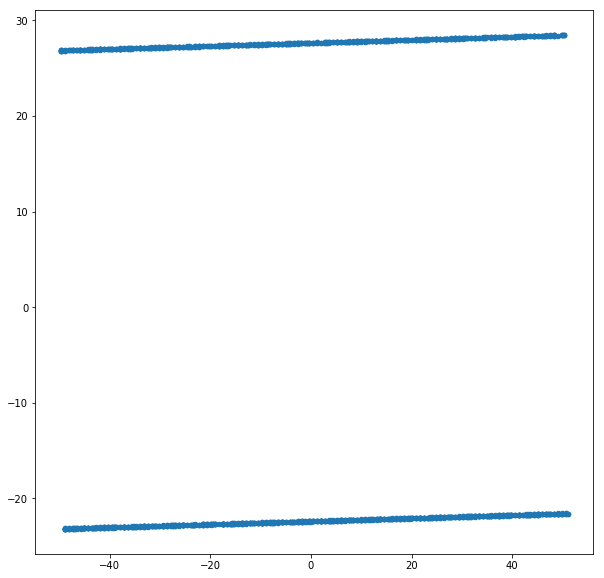

In [189]:
x_cols = trainSet.as_matrix()
from sklearn.decomposition import PCA

#Calculate the PCA for two components
pca = PCA(n_components=2)
x_converted=pca.fit_transform(x_cols)
#Create a dataframe with the x,y coordinate of the PCA
d = {'pcax':x_converted[:,0], 'pcay':x_converted[:,1]}
df = pd.DataFrame(d, index=trainSet.index)
plt.figure(figsize=(10,10))
plt.scatter(df.pcax, df.pcay, s=20)

# PCA analysis
We can observe after model complexity reduction with PCA, we can't obtain only one continuous model that represent the relation between the current consumed by the pump and the entry load or the flow delivered. 

In the next step of this study we will do an analysis using a Tree regressor to predict the flow and the entry load. Because the model is non linear or linear by interval , decision tree is a good solution to address this problem. For this analysis some function are developped to simplify the analysis and could be reused for the two analysis.


# Modeling

These functions are tools used to extract the feature set and the label set from the training and test data
Training set is obtained from the opening valve input phase and the test set is obtained from the closing valve input phase.

In [104]:
def get_feature(data):
    featureSet = data.copy();
    featureSet = featureSet.drop("EntryLoad",axis=1)
    featureSet = featureSet.drop("NormEntryLoad",axis=1)
    featureSet = featureSet.drop("Flow",axis=1) 
        
    featureSet = featureSet.drop("PumpCurrent",axis=1)
    featureSet = featureSet.drop("Cycle",axis=1)
    featureSet = featureSet.drop("Id",axis=1)
    featureSet = featureSet.drop("DateTime",axis=1)
    return featureSet

def get_featurePlusCycle(data):
    featureSet = data.copy();
    featureSet = featureSet.drop("EntryLoad",axis=1)
    featureSet = featureSet.drop("NormEntryLoad",axis=1)
    featureSet = featureSet.drop("Flow",axis=1)
        
    featureSet = featureSet.drop("PumpCurrent",axis=1)
    featureSet = featureSet.drop("Id",axis=1)
    featureSet = featureSet.drop("DateTime",axis=1)
    return featureSet

def get_label(data,label="Flow"):
    labelset = data[label].copy()
    return labelset

In [105]:
from sklearn.tree import _tree

def print_tree(t, root=0, depth=1):
    if depth == 1:
        print('def predict(X_i):')
    indent = '    '*depth
    print (indent + '# node %s: impurity = %.2f' % (str(root), t.impurity[root]))
    left_child = t.children_left[root]
    right_child = t.children_right[root]
     
    if left_child == _tree.TREE_LEAF:
        print (indent + 'return %s # (node %d)' % (str(t.value[root]), root))
    else:
        print (indent + 'if X_i[%d] < %.2f: # (node %d)' % (t.feature[root], t.threshold[root], root))
        print_tree(t, root=left_child, depth=depth+1)
         
        print (indent + 'else:')
        print_tree(t,root=right_child, depth=depth+1)

In [106]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

def fitandPredictCV(labelName,ncv=5):
    testfeatures = get_feature(testSet)
    param_grid = [
        {'min_samples_leaf':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20], 
         'max_depth':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]}
    ]
    dt_reg = DecisionTreeRegressor(random_state=2)    
    grid_search =GridSearchCV(dt_reg,param_grid,cv=ncv)
    grid_search.fit(trainfeatures,trainlabels)
    print("KFold number    :", ncv)
    print("Best Params     :" ,grid_search.best_params_)
    print("Best Score R^2  :" ,grid_search.best_score_)
    
    predictions= grid_search.best_estimator_.predict(testfeatures)
    return predictions, grid_search.best_estimator_

In [107]:
def plotLabelversusPrediction(dataset,label,prediction):
    displayds = get_featurePlusCycle(dataset)
    displayds[label]= get_label(dataset,label)
    displayds["prediction"]=prediction
    plt.figure(figsize=(15,15))
    colors = ['blue','red','magenta','yellow','cyan','black','tan','skyblue','silver','coral','peru']
    for cycle in range(1,12):
        subset = displayds[displayds.Cycle==cycle].dropna()
        cyclename = label+ ':' + str(cycle)
        if label=="NormEntryLoad":
            plt.scatter(subset.CurrentFiltered, subset.NormEntryLoad, s=20, c=colors[cycle-1], label=cyclename)
        else:
            plt.scatter(subset.CurrentFiltered, subset.Flow, s=20, c=colors[cycle-1], label=cyclename)            
        cyclename = 'Prediction: ' + str(cycle)
        plt.scatter(subset.CurrentFiltered, subset.prediction, s=20, marker='D', c=colors[cycle-1], label=cyclename)
    plt.legend()

# Predict the flow in function of the current consumed by the pump

We will keep only the features and the label we will use for the model

In [190]:
trainSet, testSet = split_train_test(pumpdataCleaned)
trainfeatures = get_feature(trainSet)
trainlabels = get_label(trainSet,"Flow")

In [191]:
trainfeatures.info()
trainfeatures.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1544 entries, 2017-04-23 19:34:18.116000 to 2017-04-23 19:54:42.984000
Data columns (total 3 columns):
OutputLoad         1544 non-null int64
PumpVelocity       1544 non-null int64
CurrentFiltered    1544 non-null float64
dtypes: float64(1), int64(2)
memory usage: 48.2 KB


,OutputLoad,PumpVelocity,CurrentFiltered
DateTime,,,
2017-04-23 19:34:18.116,50,10,0.978082
2017-04-23 16:01:01.146,100,9,1.016098
2017-04-23 17:19:37.539,100,7,0.919309
2017-04-23 20:34:05.840,50,9,0.990225
2017-04-23 18:22:17.162,100,6,0.821709


In [192]:
trainlabels.head()

DateTime
2017-04-23 19:34:18.116    237.525773
2017-04-23 16:01:01.146    289.484536
2017-04-23 17:19:37.539    274.639175
2017-04-23 20:34:05.840    252.371134
2017-04-23 18:22:17.162    256.082474
Name: Flow, dtype: float64

In [193]:
predictions,bestmodel= fitandPredictCV("Flow",11)

KFold number    : 11
Best Params     : {'max_depth': 9, 'min_samples_leaf': 17}
Best Score R^2  : 0.698867359826


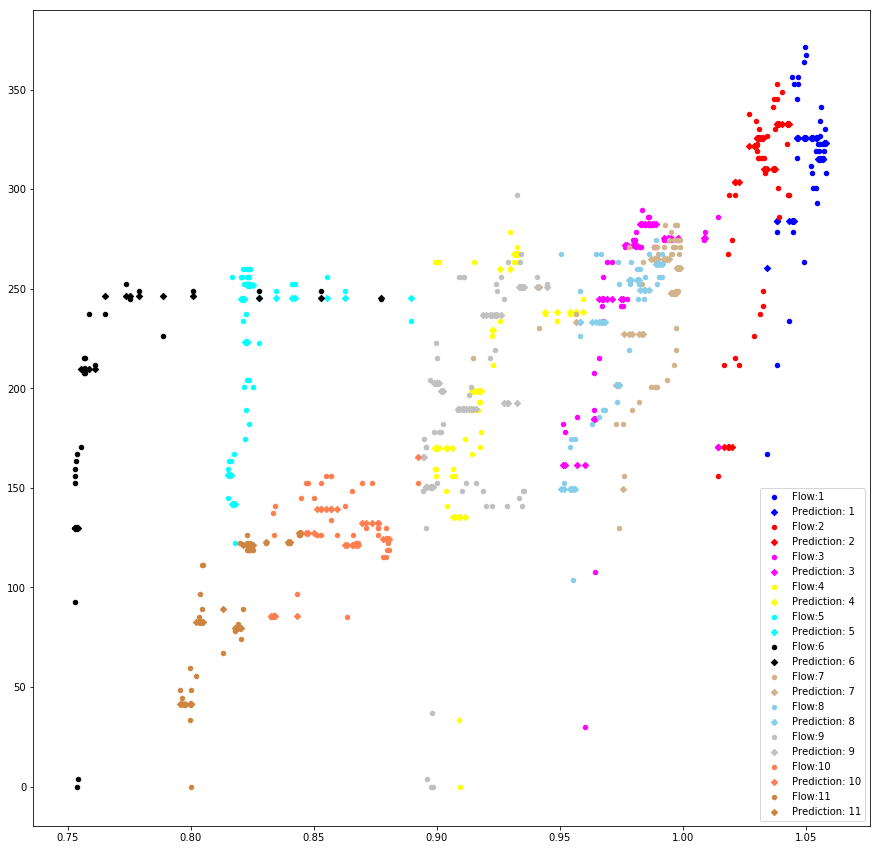

In [194]:
plotLabelversusPrediction(testSet,"Flow",predictions)

In [195]:
print_tree(bestmodel.tree_)

def predict(X_i):
    # node 0: impurity = 6341.14
    if X_i[2] < 0.98: # (node 0)
        # node 1: impurity = 4897.96
        if X_i[0] < 75.00: # (node 1)
            # node 2: impurity = 4518.27
            if X_i[2] < 0.88: # (node 2)
                # node 3: impurity = 1275.03
                if X_i[2] < 0.82: # (node 3)
                    # node 4: impurity = 901.72
                    if X_i[2] < 0.80: # (node 4)
                        # node 5: impurity = 521.04
                        return [[ 41.3814433]] # (node 5)
                    else:
                        # node 6: impurity = 558.44
                        if X_i[2] < 0.82: # (node 6)
                            # node 7: impurity = 544.26
                            if X_i[2] < 0.81: # (node 7)
                                # node 8: impurity = 349.26
                                return [[ 82.52274106]] # (node 8)
                            else:
                                # node 9: impurity = 706.

# Predict the entry load (filter clogging) in function of the current consumed by the pump

We will keep only the features and the label we will use for the model

In [196]:
trainSet, testSet = split_train_test(pumpdataCleaned)
trainfeatures = get_feature(trainSet)
trainlabels = get_label(trainSet,"NormEntryLoad")

In [197]:
trainfeatures.info()
trainfeatures.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1544 entries, 2017-04-23 19:34:18.116000 to 2017-04-23 19:54:42.984000
Data columns (total 3 columns):
OutputLoad         1544 non-null int64
PumpVelocity       1544 non-null int64
CurrentFiltered    1544 non-null float64
dtypes: float64(1), int64(2)
memory usage: 48.2 KB


,OutputLoad,PumpVelocity,CurrentFiltered
DateTime,,,
2017-04-23 19:34:18.116,50,10,0.978082
2017-04-23 16:01:01.146,100,9,1.016098
2017-04-23 17:19:37.539,100,7,0.919309
2017-04-23 20:34:05.840,50,9,0.990225
2017-04-23 18:22:17.162,100,6,0.821709


In [198]:
trainlabels.head()

DateTime
2017-04-23 19:34:18.116    15.686275
2017-04-23 16:01:01.146    99.607843
2017-04-23 17:19:37.539    87.058824
2017-04-23 20:34:05.840    53.333333
2017-04-23 18:22:17.162    61.960784
Name: NormEntryLoad, dtype: float64

In [199]:
predictions,bestmodel= fitandPredictCV("NormEntryLoad",10)

KFold number    : 10
Best Params     : {'max_depth': 13, 'min_samples_leaf': 9}
Best Score R^2  : 0.447200534547


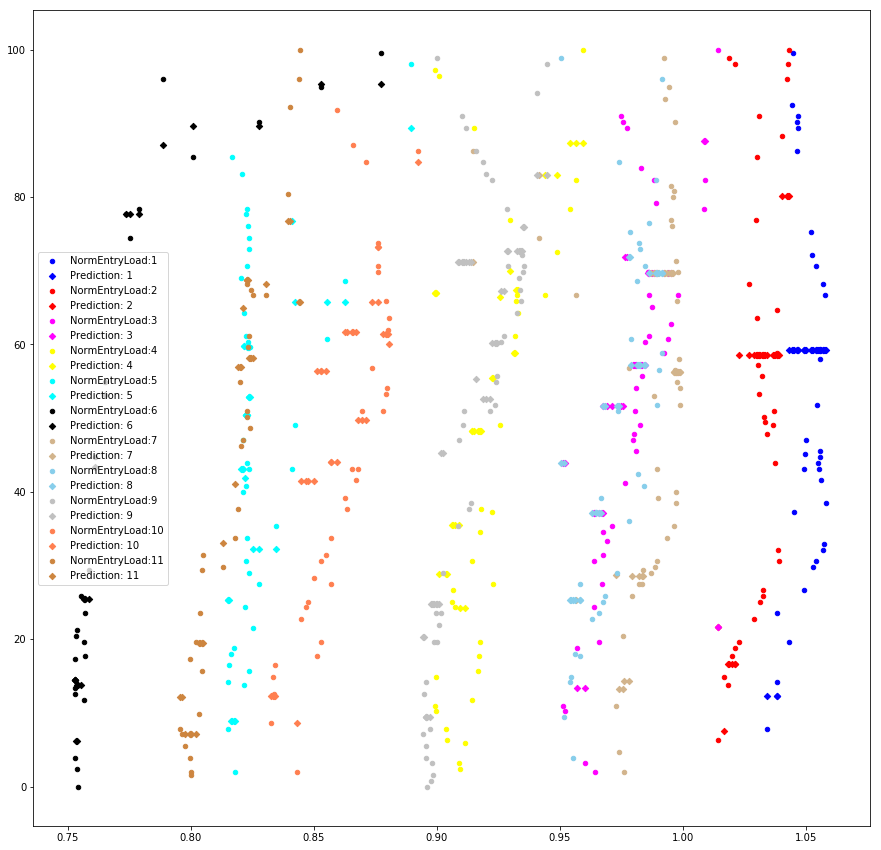

In [200]:
plotLabelversusPrediction(testSet,"NormEntryLoad",predictions)

In [201]:
print_tree(bestmodel.tree_)

def predict(X_i):
    # node 0: impurity = 846.82
    if X_i[2] < 0.76: # (node 0)
        # node 1: impurity = 89.01
        if X_i[2] < 0.76: # (node 1)
            # node 2: impurity = 60.87
            if X_i[2] < 0.75: # (node 2)
                # node 3: impurity = 17.87
                return [[ 14.50980392]] # (node 3)
            else:
                # node 4: impurity = 75.74
                if X_i[2] < 0.75: # (node 4)
                    # node 5: impurity = 42.16
                    return [[ 6.18736383]] # (node 5)
                else:
                    # node 6: impurity = 75.73
                    return [[ 13.7254902]] # (node 6)
        else:
            # node 7: impurity = 32.44
            return [[ 25.49019608]] # (node 7)
    else:
        # node 8: impurity = 834.53
        if X_i[1] < 5.50: # (node 8)
            # node 9: impurity = 386.71
            if X_i[2] < 0.77: # (node 9)
                # node 10: impurity = 98.55
                if X_i[2] < 0.76: